In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shared drives/AARN/Fake-News-RNN

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/drive
/content/drive/Shared drives/AARN/Fake-News-RNN


# 1-Preprocessing 


In [2]:
#inspecting our data
! ls
train_set='./data/train.csv'
test_set='data/test.csv'
submit='data/submit.csv'

df_train=pd.read_csv(train_set)
df_test=pd.read_csv(test_set)
df_submit=pd.read_csv(submit)
#concatinate test with submit
#print(df_submit)
df_test['label']=df_submit['label'].values
#print(df_test)

#concatinate test with train set, we will split them later 
df=pd.concat([df_train,df_test],ignore_index=True,sort=True,).reset_index()
print(df.isnull().sum()) # how much null values we have for each collumn
df=df.dropna() # delete null values
print(len(df))


 data			     FakeNews_v2.ipynb	 saved
'Fake News detector.ipynb'   FakeNews-v2.ipynb
index        0
author    2460
id           0
label        0
text        46
title      680
dtype: int64
22860


In [3]:
def lemmatization(text):
  wnl = WordNetLemmatizer()
  punctuations="?:!.,;"
  sentence_words = nltk.word_tokenize(text)
  lemmas=[]
  for word, tag in pos_tag(word_tokenize(text)):
      wntag = tag[0].lower()
      wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
      if not wntag:
              lemma = word
      else:
             lemma = wnl.lemmatize(word, wntag)
      lemmas.append(lemma)
  
  

  return " ".join(lemmas)

def stemming(text):
    ps = PorterStemmer()
    text = re.sub('[^a-zA-Z]',' ',text)  
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words("english")]
    text = " ".join(text)
    return text

def trimming(text):
    text = text.split(maxsplit=600)
    text = ' '.join(text[:600])
    return text


df['title']=df['title'].apply(lambda x: trimming(x))
df['title']=df['title'].apply(lambda x: lemmatization(x))
#df['title']=df['title'].apply(lambda x: stemming(x))
df['text']=df['text'].apply(lambda x: trimming(x))
df['text']=df['text'].apply(lambda x: lemmatization(x))
#df['text']=df['text'].apply(lambda x: stemming(x))

#df['titletext']=df['titletext'].apply(lambda x: lemmatization(x))
#df['titletext']=df['titletext'].apply(lambda x: stemming(x))
df['titletext'] = df['title'] + " . " + df['text']
df['titletext']=df['titletext'].apply(lambda x: trimming(x))
df = df.reindex(columns=['label', 'title', 'text', 'titletext'])


print(df.head())

   label  ...                                          titletext
0      1  ...  House Dem Aide : We Didn ’ t Even See Comey ’ ...
1      0  ...  FLYNN : Hillary Clinton , Big Woman on Campus ...
2      1  ...  Why the Truth Might Get You Fired . Why the Tr...
3      1  ...  15 Civilians Killed In Single US Airstrike Hav...
4      1  ...  Iranian woman jail for fictional unpublished s...

[5 rows x 4 columns]


In [15]:
!ls data

preprocessed  test.csv


In [16]:
df.drop( df[df.text.str.len() < 100].index, inplace=True) # drop short texts

# Split by label
df_real = df[df['label'] == 0]
df_fake = df[df['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = 0.7,test_size=0.3, random_state = 102)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = 0.7,test_size=0.3, random_state = 102)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = 0.7,test_size=0.3, random_state = 102)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = 0.7,test_size=0.3, random_state = 102)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv( './data/preprocessed/train.csv', index=False)
df_valid.to_csv('./data/preprocessed/valid.csv', index=False)
df_test.to_csv( './data/preprocessed/test.csv', index=False)


# 2- loading dataset

In [17]:
import torch
from torchtext.data import Field, TabularDataset, BucketIterator

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
!pip install sacremoses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='moses', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='./data/preprocessed/', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, sort=False, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=5,)

     |████████████████████████████████| 890kB 8.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7d0c24eb45d272010692a09c3c2b8a8cb7d4d10374403ebf0d9ee0fab0fe8d48
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 3- Model:

In [19]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [20]:
class FakeNewsNet(nn.Module):
    def __init__(self,vocab_size=len(text_field.vocab),hidden_size=100,num_layers=1,bi_lstm=False):
        super(FakeNewsNet, self).__init__()
        self.vocab_size=vocab_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.bi_lstm=bi_lstm
        self.embedding = nn.Embedding(self.vocab_size,256)
        self.LSTM = nn.LSTM(input_size=256,hidden_size=self.hidden_size,num_layers=self.num_layers,bidirectional=self.bi_lstm,batch_first=True)
        self.drop= nn.Dropout(p=0.5)
        if bi_lstm:
          self.out = nn.Linear(2*self.hidden_size, 1)
        else:
          self.out = nn.Linear(self.hidden_size, 1)

    def forward(self, inp, input_len):

        embeded_text = self.embedding(inp)
        packed_input = pack_padded_sequence(embeded_text, input_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.LSTM(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), input_len - 1, :self.hidden_size]
        out_reverse = output[:, 0, self.hidden_size:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.out(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# 4-Training


In [21]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to :{save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from : {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to: {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from: {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']





In [22]:
import torch.optim as optim



In [24]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 100,
          eval_every = len(train_iter) // 2,
          file_path = './saved',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print("training ...")
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = FakeNewsNet(hidden_size=300,num_layers=1,bi_lstm=True).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.01,eps=1e-6,)

train(model=model, optimizer=optimizer, num_epochs=7,eval_every=2)

FakeNewsNet(
  (embedding): Embedding(39578, 256)
  (LSTM): LSTM(256, 300, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=600, out_features=1, bias=True)
)
training ...
Epoch [1/7], Step [2/1218], Train Loss: 0.8550, Valid Loss: 0.7061
Model saved to :./saved/model.pt
Model saved to: ./saved/metrics.pt
Epoch [1/7], Step [4/1218], Train Loss: 0.6939, Valid Loss: 0.6672
Model saved to :./saved/model.pt
Model saved to: ./saved/metrics.pt
Epoch [1/7], Step [6/1218], Train Loss: 0.6564, Valid Loss: 0.6801
Epoch [1/7], Step [8/1218], Train Loss: 0.4592, Valid Loss: 1.4873
Epoch [1/7], Step [10/1218], Train Loss: 1.3791, Valid Loss: 0.6523
Model saved to :./saved/model.pt
Model saved to: ./saved/metrics.pt
Epoch [1/7], Step [12/1218], Train Loss: 0.7037, Valid Loss: 0.8266
Epoch [1/7], Step [14/1218], Train Loss: 0.9253, Valid Loss: 0.6928
Epoch [1/7], Step [16/1218], Train Loss: 0.7024, Valid Loss: 0.6436
Model saved to :./saved/mode

Model loaded from: ./saved/metrics.pt


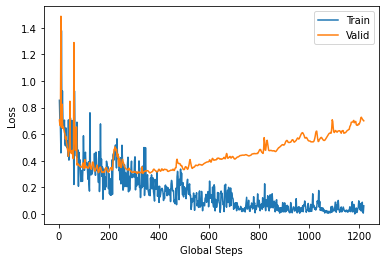

In [25]:
import matplotlib.pyplot as plt
train_loss_list, valid_loss_list, global_steps_list = load_metrics( './saved/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

FakeNewsNet(
  (embedding): Embedding(39578, 256)
  (LSTM): LSTM(256, 300, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=600, out_features=1, bias=True)
)
Model loaded from : ./saved/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8640    0.8734    0.8687      3010
           0     0.8981    0.8902    0.8942      3772

    accuracy                         0.8828      6782
   macro avg     0.8810    0.8818    0.8814      6782
weighted avg     0.8829    0.8828    0.8828      6782



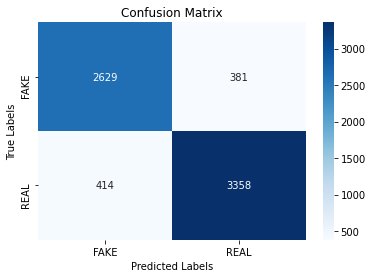

In [26]:
# Evaluation Function

def evaluate(model, test_loader, version='titletext', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
        
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = FakeNewsNet(hidden_size=300,num_layers=1,bi_lstm=True).to(device)
print(best_model)
optimizer = optim.Adam(best_model.parameters(), lr=0.01)

load_checkpoint('./saved/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [27]:
def predict(model, sentence):
    from sacremoses import MosesTokenizer
    mt = MosesTokenizer(lang='en')
    tokenized = [tok for tok in mt.tokenize(sentence)]  #tokenize the sentence 
    indexed = [text_field.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()     

In [28]:
best_model = FakeNewsNet().to(device)
print(predict(best_model,"Russian warships launched a massive missile attack on the terrorists near Aleppo"))


0.46486130356788635
